# Fake news detector

## Introduction

Can Facebook bring us to the end of democracy? It's a bit controversial question but let yourself think about how much  your life depend on this platform. <br>
Some can even say that facebook is like independent country. What can result in possibly attack on such country, the place where data about millions of people are stored? What if someone could manipulate information which occurs on your facebook board? If someone could write there anything he wanted to and you couldn't really tell that it is true or not. <br>
Of course I refer to actions which have place in 2018 caused by British company called Cambridge Analytica. It was a firm which specialized in disinformation and manipulating societies to certain actions. Their main weapons were data of about 80 millions facebook's users. With such an enormous dataset they could simulate behaviour of society and send well prepared fake news to certain target groups. It is proofed that their actions led to win of Donald Trump in USA elections in 2016. <br>
My purpose is to create a fake news detector which can easily filter true informations from fake news. Dataset contains about 6000 articles with titles mainly about politics. A lot of texts are about Hillary Clinton or mentioned earlier Donald Trump. In other work I discover that Logistic Regression outperforms other classificators so I focus on it. <br>
After this introduction we can go further. <br><br>
First of all lets import necessary libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from xgboost import XGBClassifier

from scipy.sparse import coo_matrix, hstack
import spacy
import re
import matplotlib

In [7]:
nlp = spacy.load('en')
sns.set()
matplotlib.rcParams["figure.figsize"] = 10, 10

# Importing data

In [2]:
df = pd.read_csv('news/news.csv')
df['label'] = df['label'].astype('category')
df = df.drop('Unnamed: 0', axis=1)
df.head()

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 3 columns):
title    6335 non-null object
text     6335 non-null object
label    6335 non-null category
dtypes: category(1), object(2)
memory usage: 105.4+ KB


In [4]:
df.describe()

,title,text,label
count,6335,6335,6335
unique,6256,6060,2
top,OnPolitics | 's politics blog,"Killing Obama administration rules, dismantlin...",REAL
freq,5,58,3171


To this point we can see that our dataset contains columns like title, text and of course label which tell us if the record is real or fake. The csv file had a column called 'Unnamed: 0' which consisted of indexes so I decided to remove it as it couldn't bring any important informations. <br>
Subsequently we see that we have exactly 6335 observations but not everyone of them is unique so perhaps there can be nans. <br>
Below we can see a count plot which show us that our dataset is balanced so it makes us very happy. We can rely on metrics like accuracy which works perfectly in such configuration.

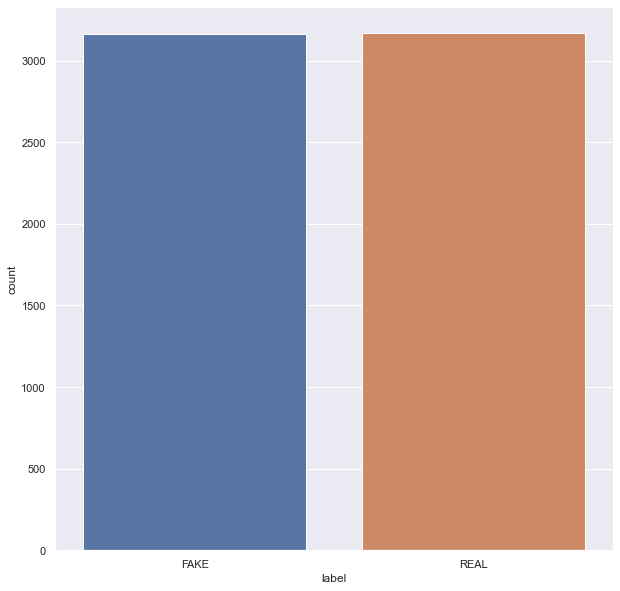

In [8]:
sns.countplot(x='label', data=df);

We can see that some of teh titles occur more than once let's check this out. <br><br>

We can see that these observations not necessary are doubled. Perhaps they could be from different sites. There are no a lot of them, so it shouldn't be bad if we keep them.

In [9]:
df['title'].value_counts()[:5]

OnPolitics | 's politics blog                                                                         5
Hillary’s “Big Tent” is Obama’s “Grand Bargain” on Steroids                                           3
Get Ready For Civil Unrest: Survey Finds That Most Americans Are Concerned About Election Violence    3
Michael Moore Owes Me $4.99                                                                           3
Clintons Are Under Multiple FBI Investigations as Agents Are Stymied                                  2
Name: title, dtype: int64

In [10]:
df[df['title']=="OnPolitics | 's politics blog"]

,title,text,label
664,OnPolitics | 's politics blog,What you need to know about the election recou...,REAL
1643,OnPolitics | 's politics blog,Who has Trump picked for his Cabinet so far?\n...,REAL
2072,OnPolitics | 's politics blog,Who has Trump appointed to his cabinet so far?...,REAL
3301,OnPolitics | 's politics blog,Who has Trump appointed to his cabinet so far?...,REAL
5127,OnPolitics | 's politics blog,Who has Trump appointed to his cabinet so far?...,REAL


What concerns me more is that there are 36 text without any letter. We can't tell what  message they provide so we should remove them.

In [11]:
df['text'].value_counts()[:3]

Killing Obama administration rules, dismantling Obamacare and pushing through tax reform are on the early to-do list.    58
                                                                                                                         36
A verdict in 2017 could have sweeping consequences for tech startups.                                                    23
Name: text, dtype: int64

#  Preprocessing

First of all let's drop nans from our data set.

In [12]:
df['text'] = df['text'].str.strip()
nans = df[df.text==''].index
df[df.text == ''].head()

,title,text,label
106,The Arcturian Group by Marilyn Raffaele Octobe...,,FAKE
710,MARKETWATCH LEFTIST: MSM’s “Blatant” Anti Trum...,,FAKE
806,Southern Poverty Law Center Targets Anti-Jihad...,,FAKE
919,Refugee Resettlement Watch: Swept Away In Nort...,,FAKE
940,Michael Bloomberg Names Technological Unemploy...,,FAKE


In [13]:
df = df.drop(nans)

Much better, because we want to know how we can perform in this moment lets quickly train an example model.

In [14]:
df['text'].value_counts()[:3]

Killing Obama administration rules, dismantling Obamacare and pushing through tax reform are on the early to-do list.    58
A verdict in 2017 could have sweeping consequences for tech startups.                                                    23
The election in 232 photos, 43 numbers and 131 quotes, from the two candidates at the center of it all.                  17
Name: text, dtype: int64

# Example model

We split our data with respect to the amount of real and fake observations both in training and testing set and after that we will use TfIdf vectorizer. <br>
TfIdf (Term frequency - inverse document frequency) is an operation which uses the frequency of appearing words in texts and also analyzes their importance to calculate the weight of particular word. It is described by following equation:

$$w_{i,j} = tf_{i,j} \cdot \log{(\frac{N}{df_i})} \quad \text{, where}$$

$w_{i,j}$ - weight of $i$-th word in $j$-th document <br>
$tf_{i,j}$- number of appearance of word $i$ in $j$-th document<br>
$df_i$ - number of documents which contain word $i$<br>
$N$ - the number of documents<br>


So for instance, if word occurs more frequently in a document then it has greater weight but if at the same time it is in many other documents then the value of the logarithm tends to 0, so the weight is smaller. <br>
We are using implemented function of sklearn module with the flag stop_words='english'. It will omit every stop word from observations, because they probably don't contribute any important information for our model. Let's check how it will perform.

In [15]:
X_train_try, X_test_try, y_train_try, y_test_try = train_test_split(df['text'], df['label'], 
                                                                    random_state=42, stratify=df['label'])

In [16]:
vectorizer = TfidfVectorizer(stop_words='english', strip_accents='ascii')
X_train_tf_try = vectorizer.fit_transform(X_train_try)
X_test_tf_try = vectorizer.transform(X_test_try)
X_train_tf_try.shape

(4724, 62359)

In [21]:
X_train_tf_try

<4724x62359 sparse matrix of type '<class 'numpy.float64'>'
	with 1255805 stored elements in Compressed Sparse Row format>

In [22]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_tf_try, y_train_try)
preds = lr.predict(X_test_tf_try)
print(classification_report(y_test_try, preds))

              precision    recall  f1-score   support

        FAKE       0.90      0.94      0.92       782
        REAL       0.94      0.90      0.92       793

    accuracy                           0.92      1575
   macro avg       0.92      0.92      0.92      1575
weighted avg       0.92      0.92      0.92      1575



First of all, we should take a look on the output of tfidf which return a sparse matrix. Sparse matrix is a matrix which contains lots of zeros and due to great size it saves only coordinates of every non-zero value with value itself. We can see that our matrix have more than 62 thousand columns which is an enormous number. Representing it via sparse matrix saves our lives (and also our CPU's). It will be crucial to decrease this number and improve our computation time. <br>
Secondary we can see that fitting our logistic regression without even hyperparameter tuning returns result of about 92% accuracy. At first when I looked at it, I was certain that something went wrong but I repeated this same process on another dataset and it returns even 98% accuracy!!!! <br>
So there is nothing left but improving this solution and decreasing dimension of the input matrix, so in other words let's continue preprocessing.

# Preprocessing - continuation

Let's clean the text from some noise like wrong characters, cites, hyperlinks and so on. I will also extract some (in my opinion) important features like if text contains hyperlinks, quotes, tweets, numerics. Furthermore let's create columns with the number of previous aspects.

In [17]:
# Lowercase letters
df['title'] = df['title'].str.lower()
df['text'] = df['text'].str.lower()

# Regex links
regex = r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?'
name = 'link'
df['text_have_' + name] = 0
df.loc[df['text'].str.contains(regex), 'text_have_'  + name] = 1
df['text_count_'+ name] = df['text'].str.count(regex)
df['text'].replace(regex, ' ', regex=True, inplace = True)
 
# Reqex quotes
regex = r'"(.*?)"|“(.*?)”|‘(.*?)’'
df['text_have_quotes'] = 0
df.loc[df['text'].str.contains(regex), 'text_have_quotes'] = 1
df['text_count_quotes'] = df['text'].str.count(regex)
df['title_have_quotes'] = 0
df.loc[df['title'].str.contains(regex), 'title_have_quotes'] = 1
df['title_count_quotes'] = df['title'].str.count(regex)
df['text'].replace(r'[“”"‘’]+', ' ', regex=True, inplace = True)
df['title'].replace(r'[“”"‘’]+', ' ', regex=True, inplace = True)


# Regex tweets
regex = r'@+\w+'
name = 'tweet'
df['text_have_' + name] = 0
df.loc[df['text'].str.contains(regex), 'text_have_'  + name] = 1
df['text_count_'+ name] = df['text'].str.count(regex)
df['title_have_'+name] = 0
df.loc[df['title'].str.contains(regex), 'title_have_'+ name] = 1
df['title_count_'+ name] = df['title'].str.count(regex)
df['text'].replace(regex, ' ', regex=True, inplace = True)
df['title'].replace(regex, ' ', regex=True, inplace = True)


# Regex numerics
df['text_count_numeric'] = df['text'].str.count('[0-9]+')
df['title_count_numeric'] = df['title'].str.count('[0-9]+')
df['text'].replace('[0-9]+', ' ', regex=True, inplace = True)
df['title'].replace('[0-9]+', ' ', regex=True, inplace = True)

# Regex 's after word
regex = r"'s|’s"
df['text'].replace(regex, '', regex=True, inplace = True)
df['title'].replace(regex, '', regex=True, inplace = True)

# Regex text cleaning
regex = r"['’\-\.,…\)\[\];\(:%$\n\?\*\+©/=!_]"
df['text'].replace(regex, ' ', regex=True, inplace = True)
df['title'].replace(regex, ' ', regex=True, inplace = True)

regex = '[–~€‹›{}]'
df['text'].replace(regex, ' ', regex=True, inplace = True)
df['title'].replace(regex, ' ', regex=True, inplace = True)

regex = r'â€\x9d'
df['text'].replace(regex, ' ', regex=True, inplace = True)
df['title'].replace(regex, ' ', regex=True, inplace = True)

# Regex multiple spacec handling
regex = r'\s\s+'
df['text'].replace(regex, ' ', regex=True, inplace = True)
df['title'].replace(regex, ' ', regex=True, inplace = True)

d:\python\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


# Creating numeric columns

Next to our binary and countable columns let's create some other numeric features like text/title length, number of words, number of unique words... After that we merge columns text and title together because each of them can contribute certain information and we want only one sparse matrix to input our model. 

In [18]:
# length of text
df['text_len'] = df['text'].apply(len)
df['title_len'] = df['title'].apply(len)

# Amount of words
df['title_word_count']  = df['title'].str.split().apply(len)
df['text_word_count']  = df['text'].str.split().apply(len)

#Amount of unique words
df['title_u_word_count']  = df['title'].str.split().apply(lambda x: len(set(x)))
df['text_u_word_count']  = df['text'].str.split().apply(lambda x: len(set(x)))


def avg_len_word(df):
    if df == []:
        return 0
    list_of_length = [len(word) for word in df]
    return np.mean(list_of_length)

df['title_avg_len_word'] = df['title'].str.split().apply(avg_len_word)
df['text_avg_len_word'] = df['text'].str.split().apply(avg_len_word)

# Connecting text and title columns
df['text + title'] = df.text + ' ' + df.title

# EDA (Exploratory Data Analysis)

After some effort in creating numeric values (mathematic models love numeric values) let's take a short look on some plots of them.

# Correlation matrix

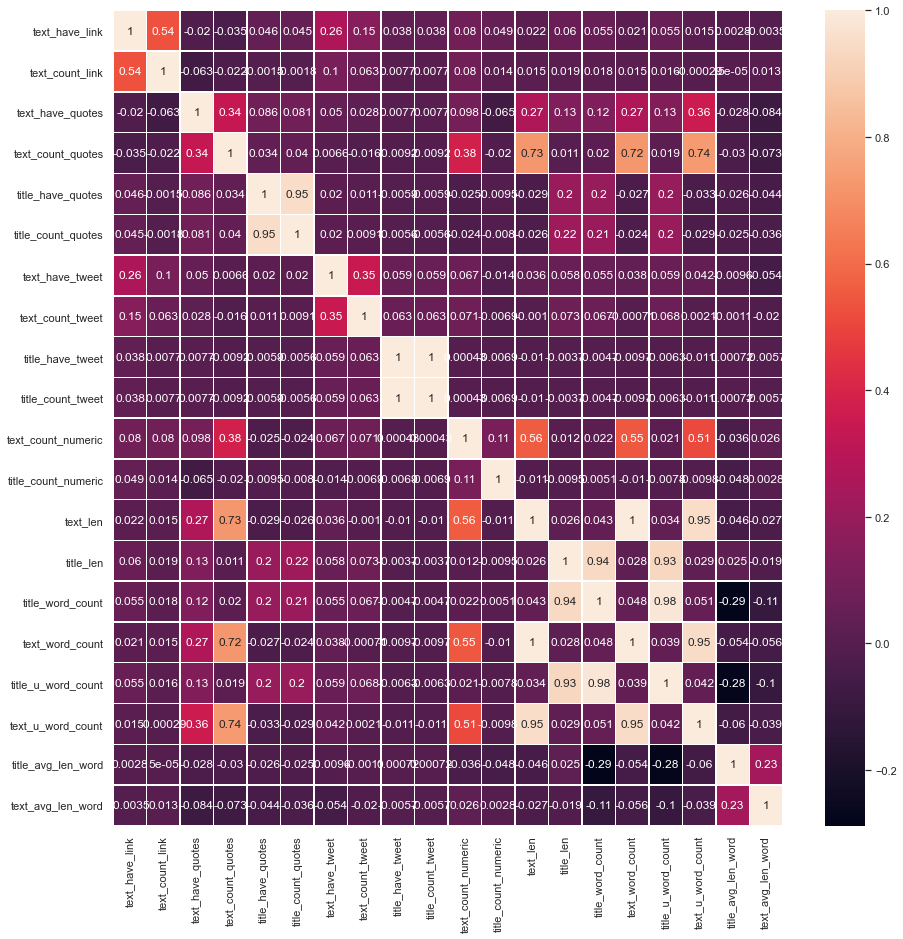

In [19]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), annot=True, linewidths=.5);

Correlation matrix is a good practice in prior feature selection. It is often important that our columns are independent (or at least uncorrelated) especially when we use logistic regression. So when we observe that some of them have either high and low value of it we should think about what we should do with this fact. <br> 
As we can see on our plot, there are a lot of features whose correlation is very high. It is logic because for example count of words should be correlated with count of unique words.

# Distribution of selected columns

Let's take a closer look on how some columns are distributed. It can give us, not only an important information about data, but it can also give us some interesting insights about fake news.

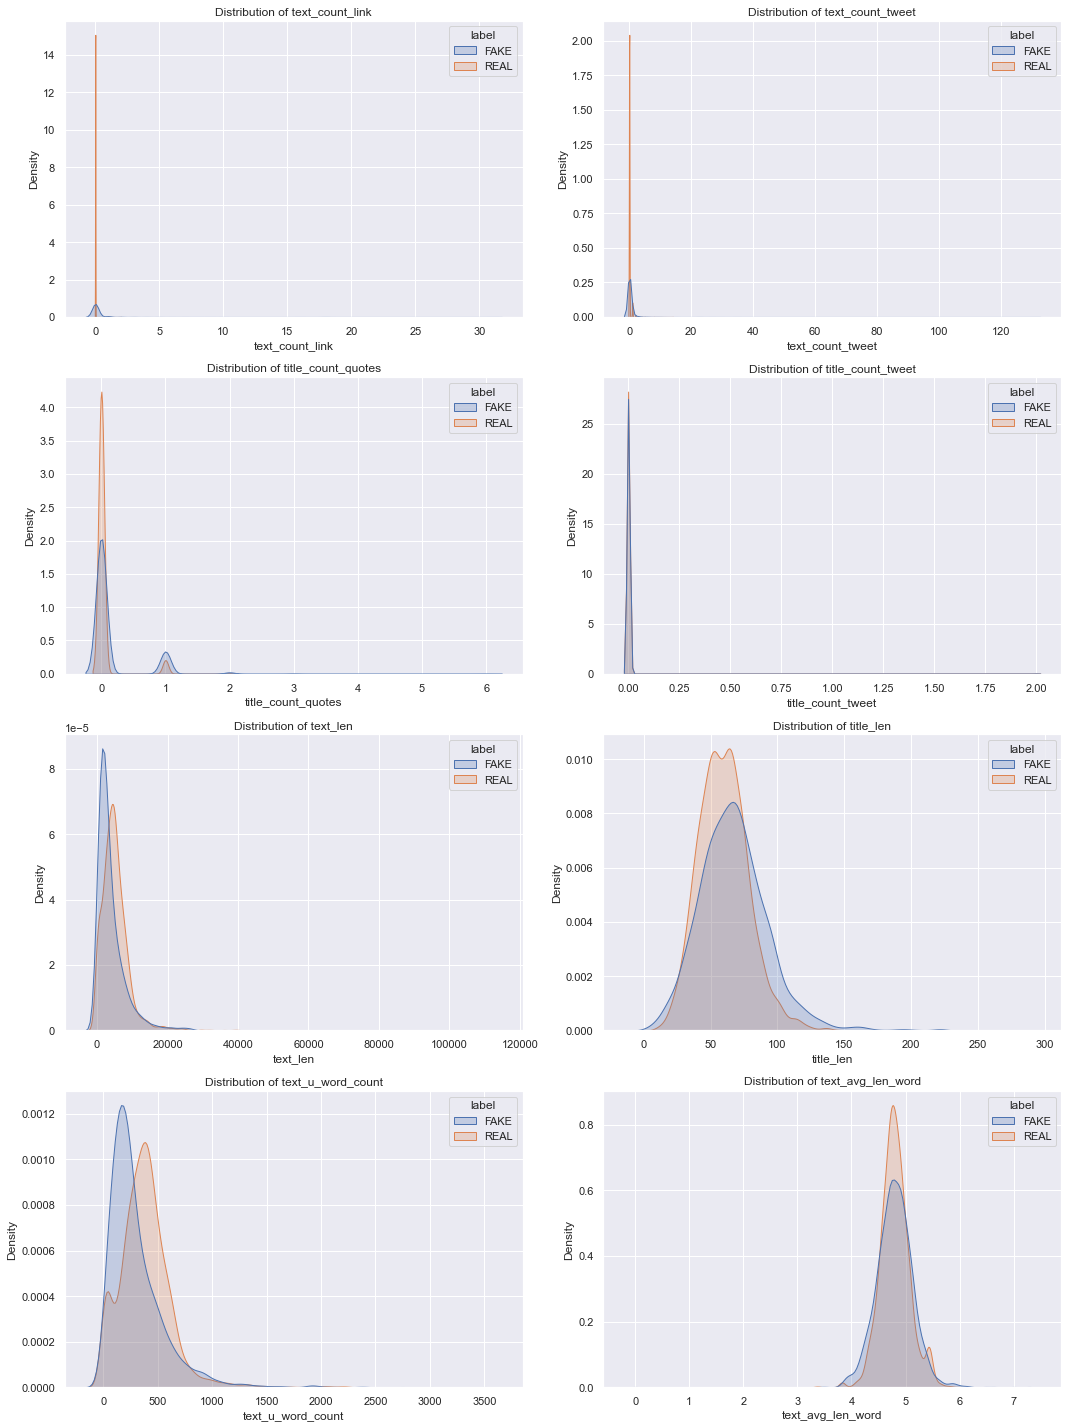

In [20]:
cols_numeric = ['text_count_link','text_count_tweet',   'title_count_quotes','title_count_tweet',
               'text_len', 'title_len',  'text_u_word_count', 'text_avg_len_word']

fig, ax = plt.subplots(4,2, figsize=(15, 20))
ax = ax.ravel()
for i in range(8):
    sns.kdeplot(x=cols_numeric[i], ax=ax[i], hue='label', data=df, fill=True)
    ax[i].set_title('Distribution of ' + cols_numeric[i])
plt.tight_layout()
plt.show()

We can observe some interesting facts. In fake news we have contact with greater amount of links, tweets and also quotes. Other features mostly overlap. What about count plots?

# Visualization of categorical values

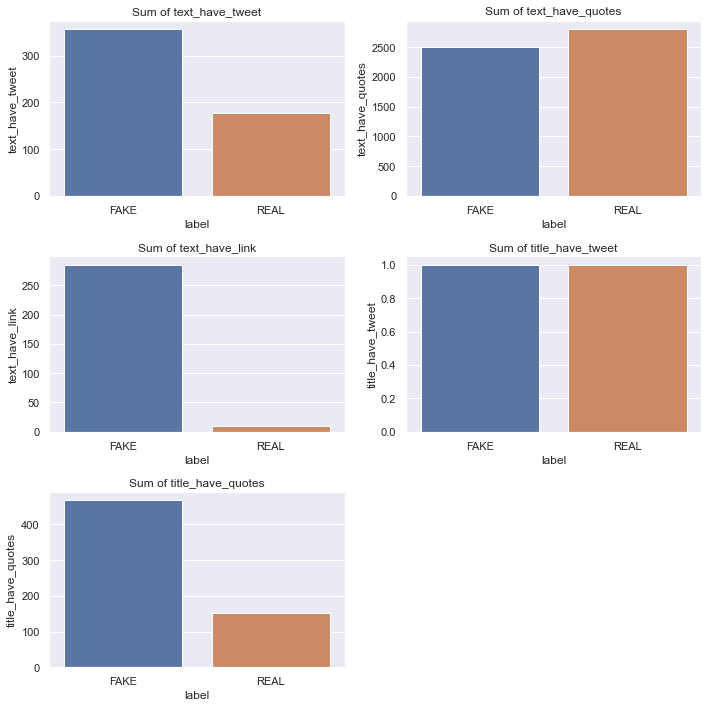

In [21]:
cols_binary = ['text_have_tweet', 'text_have_quotes', 'text_have_link',
              'title_have_tweet', 'title_have_quotes']

fig, ax = plt.subplots(3,2, figsize=(10, 10))
ax = ax.ravel()
for i in range(5):
    sns.barplot(y=cols_binary[i], x='label' ,estimator=np.sum,  ax=ax[i], data=df, ci=False)
    ax[i].set_title('Sum of ' + cols_binary[i])
fig.delaxes(ax[5])
plt.tight_layout()
plt.show()

In my opinion it provides more information. For example if title has citations it is far more certain that it is fake, the same is with texts having links and tweets. We are moving now to training our model with obtained features. I'm curious if it can pull up something valuable from all this stuff.

# Model training - with numerical columns

In [22]:
X_train_try, X_test_try, y_train_try, y_test_try = train_test_split(df.drop(['title', 'text', 'label', 'text + title']
                                                                            ,axis=1), df['label'], 
                                                                    random_state=42, stratify=df['label'])

## Forward Feature Selection

Earlier we observe that our data are highly correlated, so we should solve somehow this problem. Because of small number of features we will use forward feature selection alghorithm which trains our model with every combination of columns and return one which has the best performance.

In [30]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
# Sequential Forward Selection(sfs)
sfs = SFS(LogisticRegression(random_state=42),
          k_features=20,
          forward=True,
          floating=False,
          scoring = 'f1_macro',
         verbose=2,
         cv=10,
         n_jobs=-1)
sfs = sfs.fit(X_train_try, y_train_try)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    3.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.2s finished

[2020-12-14 20:30:01] Features: 1/20 -- score: 0.6467938917319158[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    1.0s finished

[2020-12-14 20:30:02] Features: 2/20 -- score: 0.6664999524886082[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    1.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.8s finished

[2020-12-14 20:30:04] Features: 3/20 -- score: 0.6801040796645104[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  17

In [31]:
best_features = list(sfs.subsets_[10]['feature_names'])
best_features

['text_have_link',
 'text_count_link',
 'text_count_quotes',
 'title_have_quotes',
 'title_count_quotes',
 'title_have_tweet',
 'text_count_numeric',
 'title_word_count',
 'title_u_word_count',
 'text_avg_len_word']

So we get our best combination

# Result

In [32]:
param_dict = {'penalty' : ['l1', 'l2'],
               'C' : np.logspace(1, 3, 100),}

lr = LogisticRegression(random_state=42, max_iter=500)
gs = GridSearchCV(lr, param_dict, cv=5, n_jobs=-1)
gs.fit(X_train_try[best_features], y_train_try)
preds = gs.predict(X_test_try[best_features])
print(classification_report(y_test_try, preds))

              precision    recall  f1-score   support

        FAKE       0.69      0.69      0.69       780
        REAL       0.69      0.69      0.69       791

    accuracy                           0.69      1571
   macro avg       0.69      0.69      0.69      1571
weighted avg       0.69      0.69      0.69      1571



This time we tune our model with an optimal penalty and C parameter. In this case our model performs poorly especially knowing that without any effort we could get 92% accuracy. We should start using some more powerful tools.

In [33]:
gs.best_params_

{'C': 25.353644939701113, 'penalty': 'l2'}

# Model training - with tfidf and lemmatization

Initially, we will lemmatize our words, which reduce them to their base.

In [24]:
def lemmatization(df):
    doc = nlp(df)
    return ' '.join([token.lemma_ for token in doc])

df['text+title_lemma'] = df['text + title'].apply(lambda row:lemmatization(row))

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df['text+title_lemma'],
                                                    df['label'], random_state=42, 
                                                    stratify=df['label'])

In [26]:
vectorizer = TfidfVectorizer(stop_words='english', strip_accents='ascii')
X_train_tf = vectorizer.fit_transform(X_train)
X_test_tf = vectorizer.transform(X_test)
X_train_tf.shape

(4724, 47172)

After cleaning the data and using lemmatization we could reduce the size of our matrix by about 15 thousand columns. It's great improvement. Can it perform better from our first approach?

In [27]:
param_dict = {'C' : np.logspace(1, 3, 50)}

lr = LogisticRegression(random_state=42, max_iter=500)
gs = GridSearchCV(lr, param_dict, cv=5, n_jobs=-1)
gs.fit(X_train_tf, y_train)
preds = gs.predict(X_test_tf)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

        FAKE       0.93      0.95      0.94       782
        REAL       0.95      0.93      0.94       793

    accuracy                           0.94      1575
   macro avg       0.94      0.94      0.94      1575
weighted avg       0.94      0.94      0.94      1575



In [365]:
gs.best_params_

{'C': 954.5484566618347, 'penalty': 'l2'}

In [113]:
lr = LogisticRegression(random_state=42, max_iter=500, C=954.5484566618347, penalty = 'l2')
lr.fit(X_train_tf, y_train)
preds = lr.predict(X_test_tf)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

        FAKE       0.93      0.96      0.94       780
        REAL       0.95      0.93      0.94       791

    accuracy                           0.94      1571
   macro avg       0.94      0.94      0.94      1571
weighted avg       0.94      0.94      0.94      1571



Yes, it can <3 <br>
Not only we reduce our input matrix by a lot of columns but also we improve our performance by 2%. Perhaps our numerical features can provide some information to this set.

# Model training - tfidf, lemmatization and numeric values

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['title', 'text', 'label', 'text + title'],axis=1), 
                                                    df['label'], random_state=42, stratify=df['label'])

In [39]:
vectorizer = TfidfVectorizer(stop_words='english', strip_accents='ascii')
X_train_tf = vectorizer.fit_transform(X_train['text+title_lemma'])
X_test_tf = vectorizer.transform(X_test['text+title_lemma'])

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[best_features])
X_test_scaled = scaler.transform(X_test[best_features])

We scale our numeric features and merge our matrices.

In [42]:
sparse_X_train = coo_matrix(X_train_scaled)
X_train = hstack([sparse_X_train, X_train_tf])

sparse_X_test = coo_matrix(X_test_scaled)
X_test  = hstack([sparse_X_test, X_test_tf])

In [369]:
param_dict = {'C' : np.logspace(1, 3, 100)}

lr = LogisticRegression(random_state=42, max_iter=500)
gs = GridSearchCV(lr, param_dict, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
preds = gs.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

        FAKE       0.93      0.96      0.94       782
        REAL       0.95      0.93      0.94       793

    accuracy                           0.94      1575
   macro avg       0.94      0.94      0.94      1575
weighted avg       0.94      0.94      0.94      1575



In [370]:
gs.best_params_

{'C': 135.30477745798075}

After tuning the model, we see that it doesn't improve but from a weird reason it goes down. It is an argument to not adding noise to our data.

In [43]:
lr = LogisticRegression(random_state=42, max_iter=500, C=135.30477745798075, penalty = 'l2')
lr.fit(X_train, y_train)
preds = lr.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

        FAKE       0.93      0.94      0.93       780
        REAL       0.94      0.93      0.93       791

    accuracy                           0.93      1571
   macro avg       0.93      0.93      0.93      1571
weighted avg       0.93      0.93      0.93      1571



In [44]:
df.to_csv('dane_obrobione.csv')

In [2]:
df = pd.read_csv('dane_obrobione.csv')

# Dimensionality reduction

We obtain not bad result, but due to great size of input matrix it's not quite efficient. We will do our best to decrease its dimension. The first thing coming to our mind is use to PCA alghoritm. The only problem is that standard implementation of PCA algorithm in sklearn library doesn't support operation on sparse matrices. Due to this it is prefered to use TruncatedSVD function which gives us similar result.

In [115]:
X_train, X_test, y_train, y_test = train_test_split(df['text+title_lemma'], 
                                                    df['label'], random_state=42, 
                                                    stratify=df['label'])

vectorizer = TfidfVectorizer(stop_words='english', strip_accents='ascii')
X_train_tf = vectorizer.fit_transform(X_train)
X_test_tf = vectorizer.transform(X_test)

My approach was to check in a while loop how much can we decrease our dimensionality to obtain close result to our model. It was also very interesting how it will change the value of total explained variance.

In [49]:
n = 1000
acc = 0.92
lr = LogisticRegression(random_state=42, max_iter=500)
while acc <= 0.93:
    pca = TruncatedSVD(n_components = n)
    X_train_reduced = pca.fit_transform(X_train_tf)
    X_test_reduced = pca.transform(X_test_tf)

    param_dict = {'C' : np.logspace(1, 3, 40),}
    gs = GridSearchCV(lr, param_dict, cv=5)
    gs.fit(X_train_reduced, y_train)
    acc = gs.best_score_
    explained = pca.explained_variance_ratio_.sum()
    n += 200
    print(acc, explained, n)
    
preds = gs.predict(X_test_reduced)
print(classification_report(y_test, preds))

0.9270118630291814 0.6457378071581632 1200
0.9278608947817532 0.6925993655677218 1400
0.9289202144306129 0.7337792635493985 1600
0.9278606696341125 0.7702783335053389 1800
0.9274358160363658 0.8026376991233827 2000
0.9274351405934442 0.8313242145082423 2200
0.9291338795415094 0.8567553311910245 2400
0.9297705970690281 0.8792998480645016 2600
0.9304070894489062 0.8992422221097228 2800
              precision    recall  f1-score   support

        FAKE       0.91      0.95      0.93       780
        REAL       0.94      0.91      0.93       791

    accuracy                           0.93      1571
   macro avg       0.93      0.93      0.93      1571
weighted avg       0.93      0.93      0.93      1571



As we can see we could obtain 93 % accuracy alongside with nearly 90% explained variance with 2800 columns. So the result isn't as far from the original but we could reduce the matrix rank by about next 43 thousand. It is magnificent score. Oddly enough, we removed only 10% information from our dataset. 

# Final result

I increase dimensionality reduction to 3000 because I observed that it gave us the 94% accuracy level and with such a reduction 200 more columns aren't a big deal. Also the total explained variance increased by 3 percent what tell us that dimension of 3000 is very unstable with containing our dataset information. Small deviations in this parameter can result in relatively big difference in explained variance ratio.

In [117]:
pca = TruncatedSVD(n_components = 3000)
X_train_reduced = pca.fit_transform(X_train_tf)

X_test_reduced = pca.transform(X_test_tf)

In [118]:
pca.explained_variance_ratio_.sum()

0.9324457641774976

In [385]:
param_dict = {'C' : np.logspace(1, 3, 50),}

lr = LogisticRegression(random_state=42, max_iter=500)
gs = GridSearchCV(lr, param_dict, cv=5, n_jobs=-1)
gs.fit(X_train_reduced, y_train)
preds = gs.predict(X_test_reduced)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

        FAKE       0.93      0.96      0.94       782
        REAL       0.96      0.93      0.94       793

    accuracy                           0.94      1575
   macro avg       0.94      0.94      0.94      1575
weighted avg       0.94      0.94      0.94      1575



In [387]:
gs.best_params_

{'C': 40.94915062380423}

In [119]:
lr = LogisticRegression(random_state=42, max_iter=500, C=40.94915062380423)
lr.fit(X_train_reduced, y_train)
preds = lr.predict(X_test_reduced)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

        FAKE       0.92      0.95      0.94       780
        REAL       0.95      0.92      0.94       791

    accuracy                           0.94      1571
   macro avg       0.94      0.94      0.94      1571
weighted avg       0.94      0.94      0.94      1571



# Probability density function of being a fake news

In conclusion I prepared some interesting insights as for example how does the pdf of being fake news looks like. As we know there are a lot of comunicates that are hard to interpret in the state of real or fake. Some information can consist of half real and half fake. I was curious about how our model will interpret it. As we can see that mostly it was confident in classification of texts. Only small factors of observations was in the middle. It is right with intuition because logistic regression fit the data with sigmoid function which probability near median are in very short interval.

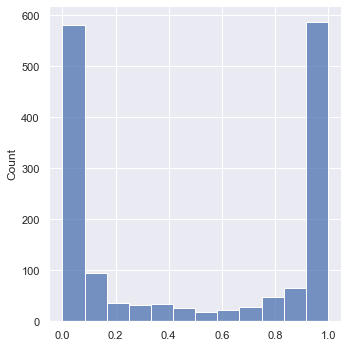

In [55]:
sns.displot(lr.predict_proba(X_test_reduced)[:, 1]);

# Porównanie z XGBoostem

I also check how other model can perform on our data. I checked one of the best algorithms which is XGBoost. I try to tune hyperparameters which took a lot of time and what is interesting its result was even worse than the example model. XGBoost also had problems with a great input vector (3000 columns). This shows us that logistic regression was pretty good pick for this problem.

In [56]:
params = {"learning_rate"    : [0.05,  0.15, 0.30] ,
 "max_depth"        : [ 3, 8, 12],
 "min_child_weight" : [ 1, 3 ],
 "gamma"            : [ 0.0, 0.2 , 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.7 ] }


xgb = XGBClassifier(random_state=42, n_jobs=-1)
gs_xgb = GridSearchCV(xgb, param_grid=params, cv=5, verbose=30, n_jobs=-1, )
gs_xgb.fit(X_train_reduced, y_train)
preds = gs_xgb.predict(X_test_reduced)
print(classification_report(y_test, preds))

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  4

[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed: 37.6min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 37.7min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed: 37.7min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed: 38.0min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed: 38.0min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 38.2min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 38.2min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed: 39.9min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed: 39.9min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 40.5min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed: 40.5min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed: 40.6min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed: 40.8min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed: 40.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 41.0min
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed: 41.8min
[Paralle

[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed: 72.6min
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed: 72.7min
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed: 73.6min
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed: 73.7min
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed: 74.0min
[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed: 74.0min
[Parallel(n_jobs=-1)]: Done 271 tasks      | elapsed: 74.0min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 74.1min
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed: 74.2min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed: 74.5min
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed: 75.0min
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed: 75.1min
[Parallel(n_jobs=-1)]: Done 277 tasks      | elapsed: 75.4min
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed: 75.5min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed: 75.5min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 75.5min
[Paralle

[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed: 117.5min
[Parallel(n_jobs=-1)]: Done 398 tasks      | elapsed: 117.6min
[Parallel(n_jobs=-1)]: Done 399 tasks      | elapsed: 117.6min
[Parallel(n_jobs=-1)]: Done 400 tasks      | elapsed: 118.0min
[Parallel(n_jobs=-1)]: Done 401 tasks      | elapsed: 120.0min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 120.0min
[Parallel(n_jobs=-1)]: Done 403 tasks      | elapsed: 120.1min
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed: 120.1min
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed: 120.4min
[Parallel(n_jobs=-1)]: Done 406 tasks      | elapsed: 120.4min
[Parallel(n_jobs=-1)]: Done 407 tasks      | elapsed: 120.7min
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed: 120.8min
[Parallel(n_jobs=-1)]: Done 409 tasks      | elapsed: 122.8min
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed: 122.8min
[Parallel(n_jobs=-1)]: Done 411 tasks      | elapsed: 123.6min
[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed: 1

[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed: 159.6min
[Parallel(n_jobs=-1)]: Done 529 tasks      | elapsed: 161.6min
[Parallel(n_jobs=-1)]: Done 530 tasks      | elapsed: 161.6min
[Parallel(n_jobs=-1)]: Done 531 tasks      | elapsed: 162.1min
[Parallel(n_jobs=-1)]: Done 532 tasks      | elapsed: 162.6min
[Parallel(n_jobs=-1)]: Done 533 tasks      | elapsed: 162.6min
[Parallel(n_jobs=-1)]: Done 534 tasks      | elapsed: 162.7min
[Parallel(n_jobs=-1)]: Done 535 tasks      | elapsed: 162.8min
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed: 162.8min
[Parallel(n_jobs=-1)]: Done 537 tasks      | elapsed: 164.1min
[Parallel(n_jobs=-1)]: Done 538 tasks      | elapsed: 164.1min
[Parallel(n_jobs=-1)]: Done 539 tasks      | elapsed: 164.6min
[Parallel(n_jobs=-1)]: Done 540 tasks      | elapsed: 165.0min
[Parallel(n_jobs=-1)]: Done 541 tasks      | elapsed: 165.1min
[Parallel(n_jobs=-1)]: Done 542 tasks      | elapsed: 165.1min
[Parallel(n_jobs=-1)]: Done 543 tasks      | elapsed: 1

[Parallel(n_jobs=-1)]: Done 659 tasks      | elapsed: 232.1min
[Parallel(n_jobs=-1)]: Done 660 tasks      | elapsed: 232.1min
[Parallel(n_jobs=-1)]: Done 661 tasks      | elapsed: 233.1min
[Parallel(n_jobs=-1)]: Done 662 tasks      | elapsed: 233.3min
[Parallel(n_jobs=-1)]: Done 663 tasks      | elapsed: 234.2min
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed: 234.3min
[Parallel(n_jobs=-1)]: Done 665 tasks      | elapsed: 234.5min
[Parallel(n_jobs=-1)]: Done 666 tasks      | elapsed: 234.5min
[Parallel(n_jobs=-1)]: Done 667 tasks      | elapsed: 235.5min
[Parallel(n_jobs=-1)]: Done 668 tasks      | elapsed: 235.6min
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed: 235.7min
[Parallel(n_jobs=-1)]: Done 670 tasks      | elapsed: 236.2min
[Parallel(n_jobs=-1)]: Done 671 tasks      | elapsed: 239.5min
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed: 239.6min
[Parallel(n_jobs=-1)]: Done 673 tasks      | elapsed: 239.7min
[Parallel(n_jobs=-1)]: Done 674 tasks      | elapsed: 2

[Parallel(n_jobs=-1)]: Done 790 tasks      | elapsed: 301.7min
[Parallel(n_jobs=-1)]: Done 791 tasks      | elapsed: 305.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 305.5min
[Parallel(n_jobs=-1)]: Done 793 tasks      | elapsed: 305.7min
[Parallel(n_jobs=-1)]: Done 794 tasks      | elapsed: 305.7min
[Parallel(n_jobs=-1)]: Done 795 tasks      | elapsed: 306.0min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 314.2min finished


              precision    recall  f1-score   support

        FAKE       0.91      0.89      0.90       780
        REAL       0.89      0.91      0.90       791

    accuracy                           0.90      1571
   macro avg       0.90      0.90      0.90      1571
weighted avg       0.90      0.90      0.90      1571



In [59]:
xgb.fit(X_train_reduced, y_train)
preds = xgb.predict(X_test_reduced)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

        FAKE       0.90      0.90      0.90       780
        REAL       0.90      0.90      0.90       791

    accuracy                           0.90      1571
   macro avg       0.90      0.90      0.90      1571
weighted avg       0.90      0.90      0.90      1571



In [60]:
xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [58]:
gs_xgb.best_params_

{'colsample_bytree': 0.4,
 'gamma': 0.0,
 'learning_rate': 0.15,
 'max_depth': 8,
 'min_child_weight': 3}

# Visualization in 2D

So far we have reduced our dimension by 60 thousand columns. Why not to try reduce it to a plane? Of course because it performs poorly. Explained variance ratio is on 4% level which is terrific. Model trained on such sample also don't give us super result. 61% accuracy is so bad that we could randomly predict our text as well. But let's take a look on plot. Perhaps there can be some valid observations.

In [5]:
pca2 = TruncatedSVD(n_components = 2)
X_train_reduced = pca2.fit_transform(X_train_tf)

X_test_reduced = pca2.transform(X_test_tf)

pca2.explained_variance_ratio_.sum()

0.044228829276449146

In [6]:
param_dict = {'C' : np.logspace(1, 3, 50),}

lr = LogisticRegression(random_state=42, max_iter=500)
gs2 = GridSearchCV(lr, param_dict, cv=5, n_jobs=-1)
gs2.fit(X_train_reduced, y_train)

preds = gs2.predict(X_test_reduced)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

        FAKE       0.59      0.68      0.63       780
        REAL       0.63      0.53      0.58       791

    accuracy                           0.61      1571
   macro avg       0.61      0.61      0.60      1571
weighted avg       0.61      0.61      0.60      1571



It's totally random. Fake news and real texts are mixed with each other and we can't see unique clusters.

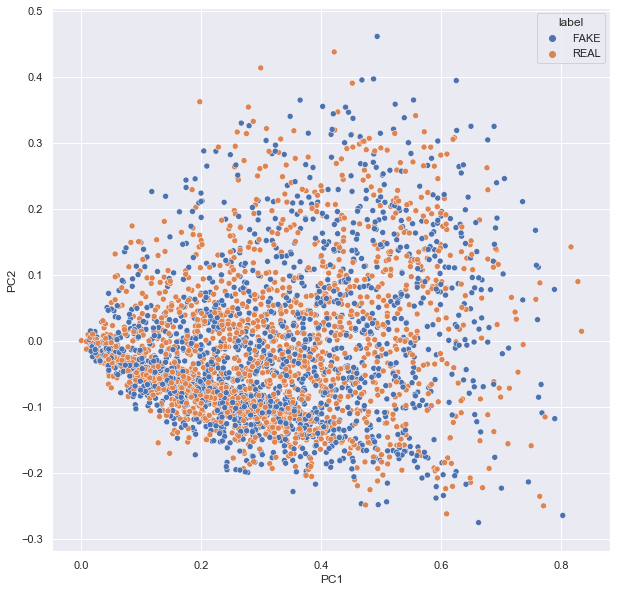

In [9]:
df_pca = pd.DataFrame(X_train_reduced, columns=['PC1', 'PC2'])

df_pca['label'] = y_train

sns.scatterplot(x='PC1', y='PC2', data=df_pca, hue='label');

# TSNE

What about another dimensionality reduction algorithm? Perhaps it can show us something more interesting. Let's check how TSNE does the work.

In [379]:
tsne = TSNE(n_components = 2)
X_train_reduced = tsne.fit_transform(X_train_tf)

X_test_reduced = tsne.fit_transform(X_test_tf)

param_dict = {'C' : np.logspace(1, 3, 50)}

lr2 = LogisticRegression(random_state=42, max_iter=500)
gs2 = GridSearchCV(lr2, param_dict, cv=5, n_jobs=-1)
gs2.fit(X_train_reduced, y_train)

preds = gs2.predict(X_test_reduced)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

        FAKE       0.53      0.50      0.51       782
        REAL       0.53      0.56      0.55       793

    accuracy                           0.53      1575
   macro avg       0.53      0.53      0.53      1575
weighted avg       0.53      0.53      0.53      1575



It is even worse and if we take a look on plot below we can see that this time also clusters are mixed with each other. There are also some outliers (mostly fake news) but it is not significant.

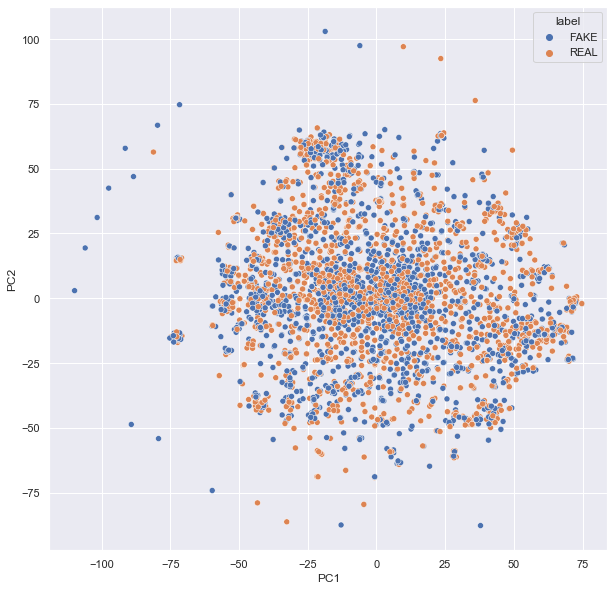

In [380]:
df_pca = pd.DataFrame(X_train_reduced, columns=['PC1', 'PC2'])

df_pca['label'] = y_train

sns.scatterplot(x='PC1', y='PC2', data=df_pca, hue='label')

# KMeans

We could train our model because we had information about our text. Dataset was labeled because someone took his time and did it. What if we didn't have those informations on the beginning. In other words let's check what happens if we try to classify our data with clusterization algorithm. We use for this purpose KMeans. 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['text+title_lemma'], 
                                                    df['label'], random_state=42, 
                                                    stratify=df['label'])

vectorizer = TfidfVectorizer(stop_words='english', strip_accents='ascii')
X_train_tf = vectorizer.fit_transform(X_train)
X_test_tf = vectorizer.transform(X_test)

In [11]:
pca = TruncatedSVD(n_components = 3000)
X_train_reduced = pca.fit_transform(X_train_tf)

X_test_reduced = pca.transform(X_test_tf)

In [12]:
pca.explained_variance_ratio_.sum()

0.9323357407949051

In [13]:
from sklearn.cluster import KMeans

scaler= MinMaxScaler()
X_train = scaler.fit_transform(X_train_reduced)
X_test = scaler.fit_transform(X_test_reduced)
km = KMeans(n_clusters=2, random_state=8)
km.fit(X_train)
preds = km.fit_predict(X_test)

In [17]:
y_test1 = y_test.map({'REAL':1, 'FAKE':0})
print(classification_report(y_test1, preds))

              precision    recall  f1-score   support

           0       0.50      0.99      0.66       780
           1       0.57      0.02      0.03       791

    accuracy                           0.50      1571
   macro avg       0.53      0.50      0.35      1571
weighted avg       0.53      0.50      0.34      1571



In [18]:
y_test2 = y_test.map({'REAL':0, 'FAKE':1})
print(classification_report(y_test2, preds))

              precision    recall  f1-score   support

           0       0.50      0.98      0.67       791
           1       0.43      0.01      0.02       780

    accuracy                           0.50      1571
   macro avg       0.47      0.50      0.34      1571
weighted avg       0.47      0.50      0.35      1571



The result is almost random. As we can see clusterization algorithm couldn't separate well our classes. It shows us that the effort sacred to labeled observation was needed. But now as the model is trained we can use it to detect some fake news provided by different sources.

#  Summary

We start with not bad solution, but we wanted to optimize it. In these case texts were cleaned and certain informations were extracted from them. We trained logistic regression which was a great pick in comparison with for example XGBoost. The problem was with a great matrix generated with TfIDF, so we reduce dimensionality with Truncated SVD algorithm. We could compress the matrix from 62 thousand columns to only 3 thousand maintaining the same accuracy.